## Import Libraries



In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import pickle
from IPython.core.display import HTML
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

pd.set_option('display.max_columns',None)
sns.set_style('whitegrid')

## Import Data

In [2]:
train=pd.read_csv("train.csv")
submission=pd.read_csv("sample_submission.csv")
test=pd.read_csv("test.csv")

In [3]:
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [4]:
features=train.columns[1:].tolist()

original=pd.read_csv("Faults.NNA",sep="\t",names=features)
original.to_csv("Steel Plates Faults.csv",index=False)
original.head()



,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


### Compare train and original data

In [5]:
print(original.shape)
original.columns.tolist()

(1941, 34)


['X_Minimum',
 'X_Maximum',
 'Y_Minimum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'TypeOfSteel_A400',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas',
 'Pastry',
 'Z_Scratch',
 'K_Scatch',
 'Stains',
 'Dirtiness',
 'Bumps',
 'Other_Faults']

In [6]:
print(train.shape)
train.columns.tolist()

(19219, 35)


['id',
 'X_Minimum',
 'X_Maximum',
 'Y_Minimum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'TypeOfSteel_A400',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas',
 'Pastry',
 'Z_Scratch',
 'K_Scatch',
 'Stains',
 'Dirtiness',
 'Bumps',
 'Other_Faults']

Drop id column from train and test data

In [7]:
train.drop(columns=['id'],axis=1,inplace=True)
test.drop(columns=['id'],axis=1,inplace=True)

Concatenate original and train

In [8]:
train=pd.concat(objs=[train,original],axis=0)
train.shape

(21160, 34)

In [9]:
print(f"Train Data: {train.shape}\nTest Data: {test.shape}\n")

print(f"Train data contain {np.round((len(train)*100)/(len(train)+len(test)),2)}% of all obervations")
print(f"Test data contain {np.round((len(test)*100)/(len(train)+len(test)),2)}% of all obervations")

Train Data: (21160, 34)
Test Data: (12814, 27)

Train data contain 62.28% of all obervations
Test data contain 37.72% of all obervations


## Display descriptive Statistics of Train Data

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
X_Minimum,21160.0,6.971301e+02,5.320546e+02,0.0000,50.0000,7.540000e+02,1.145000e+03,1.705000e+03
X_Maximum,21160.0,7.413922e+02,5.011601e+02,4.0000,214.0000,7.720000e+02,1.161000e+03,1.713000e+03
Y_Minimum,21160.0,1.831495e+06,1.892922e+06,6712.0000,639490.0000,1.378585e+06,2.339627e+06,1.298766e+07
Y_Maximum,21160.0,1.828639e+06,1.886266e+06,6724.0000,639507.0000,1.378261e+06,2.336466e+06,1.298769e+07
Pixels_Areas,21160.0,1.703241e+03,3.884801e+03,2.0000,88.0000,1.690000e+02,6.590000e+02,1.526550e+05
X_Perimeter,21160.0,9.714074e+01,1.925100e+02,2.0000,15.0000,2.500000e+01,6.700000e+01,1.044900e+04
Y_Perimeter,21160.0,6.585246e+01,1.611876e+02,1.0000,14.0000,2.400000e+01,6.200000e+01,1.815200e+04
Sum_of_Luminosity,21160.0,1.931736e+05,4.489348e+05,250.0000,9778.0000,1.840200e+04,6.841600e+04,1.159141e+07
Minimum_of_Luminosity,21160.0,8.478459e+01,2.912134e+01,0.0000,68.0000,9.000000e+01,1.050000e+02,2.030000e+02
Maximum_of_Luminosity,21160.0,1.287892e+02,1.467294e+01,37.0000,124.0000,1.270000e+02,1.350000e+02,2.530000e+02


In [11]:
contains_inf=train.isin([np.inf,-np.inf]).any().any()
contains_inf

False

## Feature Engineering

In [12]:
train.duplicated().sum()

0

One Hot Encoding

In [48]:
target_cols=['Pastry',
  'Z_Scratch',
  'K_Scatch',
  'Stains',
  'Dirtiness',
  'Bumps',
  'Other_Faults']

X=train.drop(labels=target_cols,axis=1)
X=pd.get_dummies(data=X,drop_first=True,dtype=int)
test=pd.get_dummies(data=test,drop_first=True,dtype=int)

print(f"Features shape: {X.shape}")
X.head()


Features shape: (21160, 27)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998


In [14]:
y=train[target_cols]
y.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1


In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21160 entries, 0 to 1940
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              21160 non-null  int64  
 1   X_Maximum              21160 non-null  int64  
 2   Y_Minimum              21160 non-null  int64  
 3   Y_Maximum              21160 non-null  int64  
 4   Pixels_Areas           21160 non-null  int64  
 5   X_Perimeter            21160 non-null  int64  
 6   Y_Perimeter            21160 non-null  int64  
 7   Sum_of_Luminosity      21160 non-null  int64  
 8   Minimum_of_Luminosity  21160 non-null  int64  
 9   Maximum_of_Luminosity  21160 non-null  int64  
 10  Length_of_Conveyer     21160 non-null  int64  
 11  TypeOfSteel_A300       21160 non-null  int64  
 12  TypeOfSteel_A400       21160 non-null  int64  
 13  Steel_Plate_Thickness  21160 non-null  int64  
 14  Edges_Index            21160 non-null  float64
 15  Emp

### Display histograms of Distribution

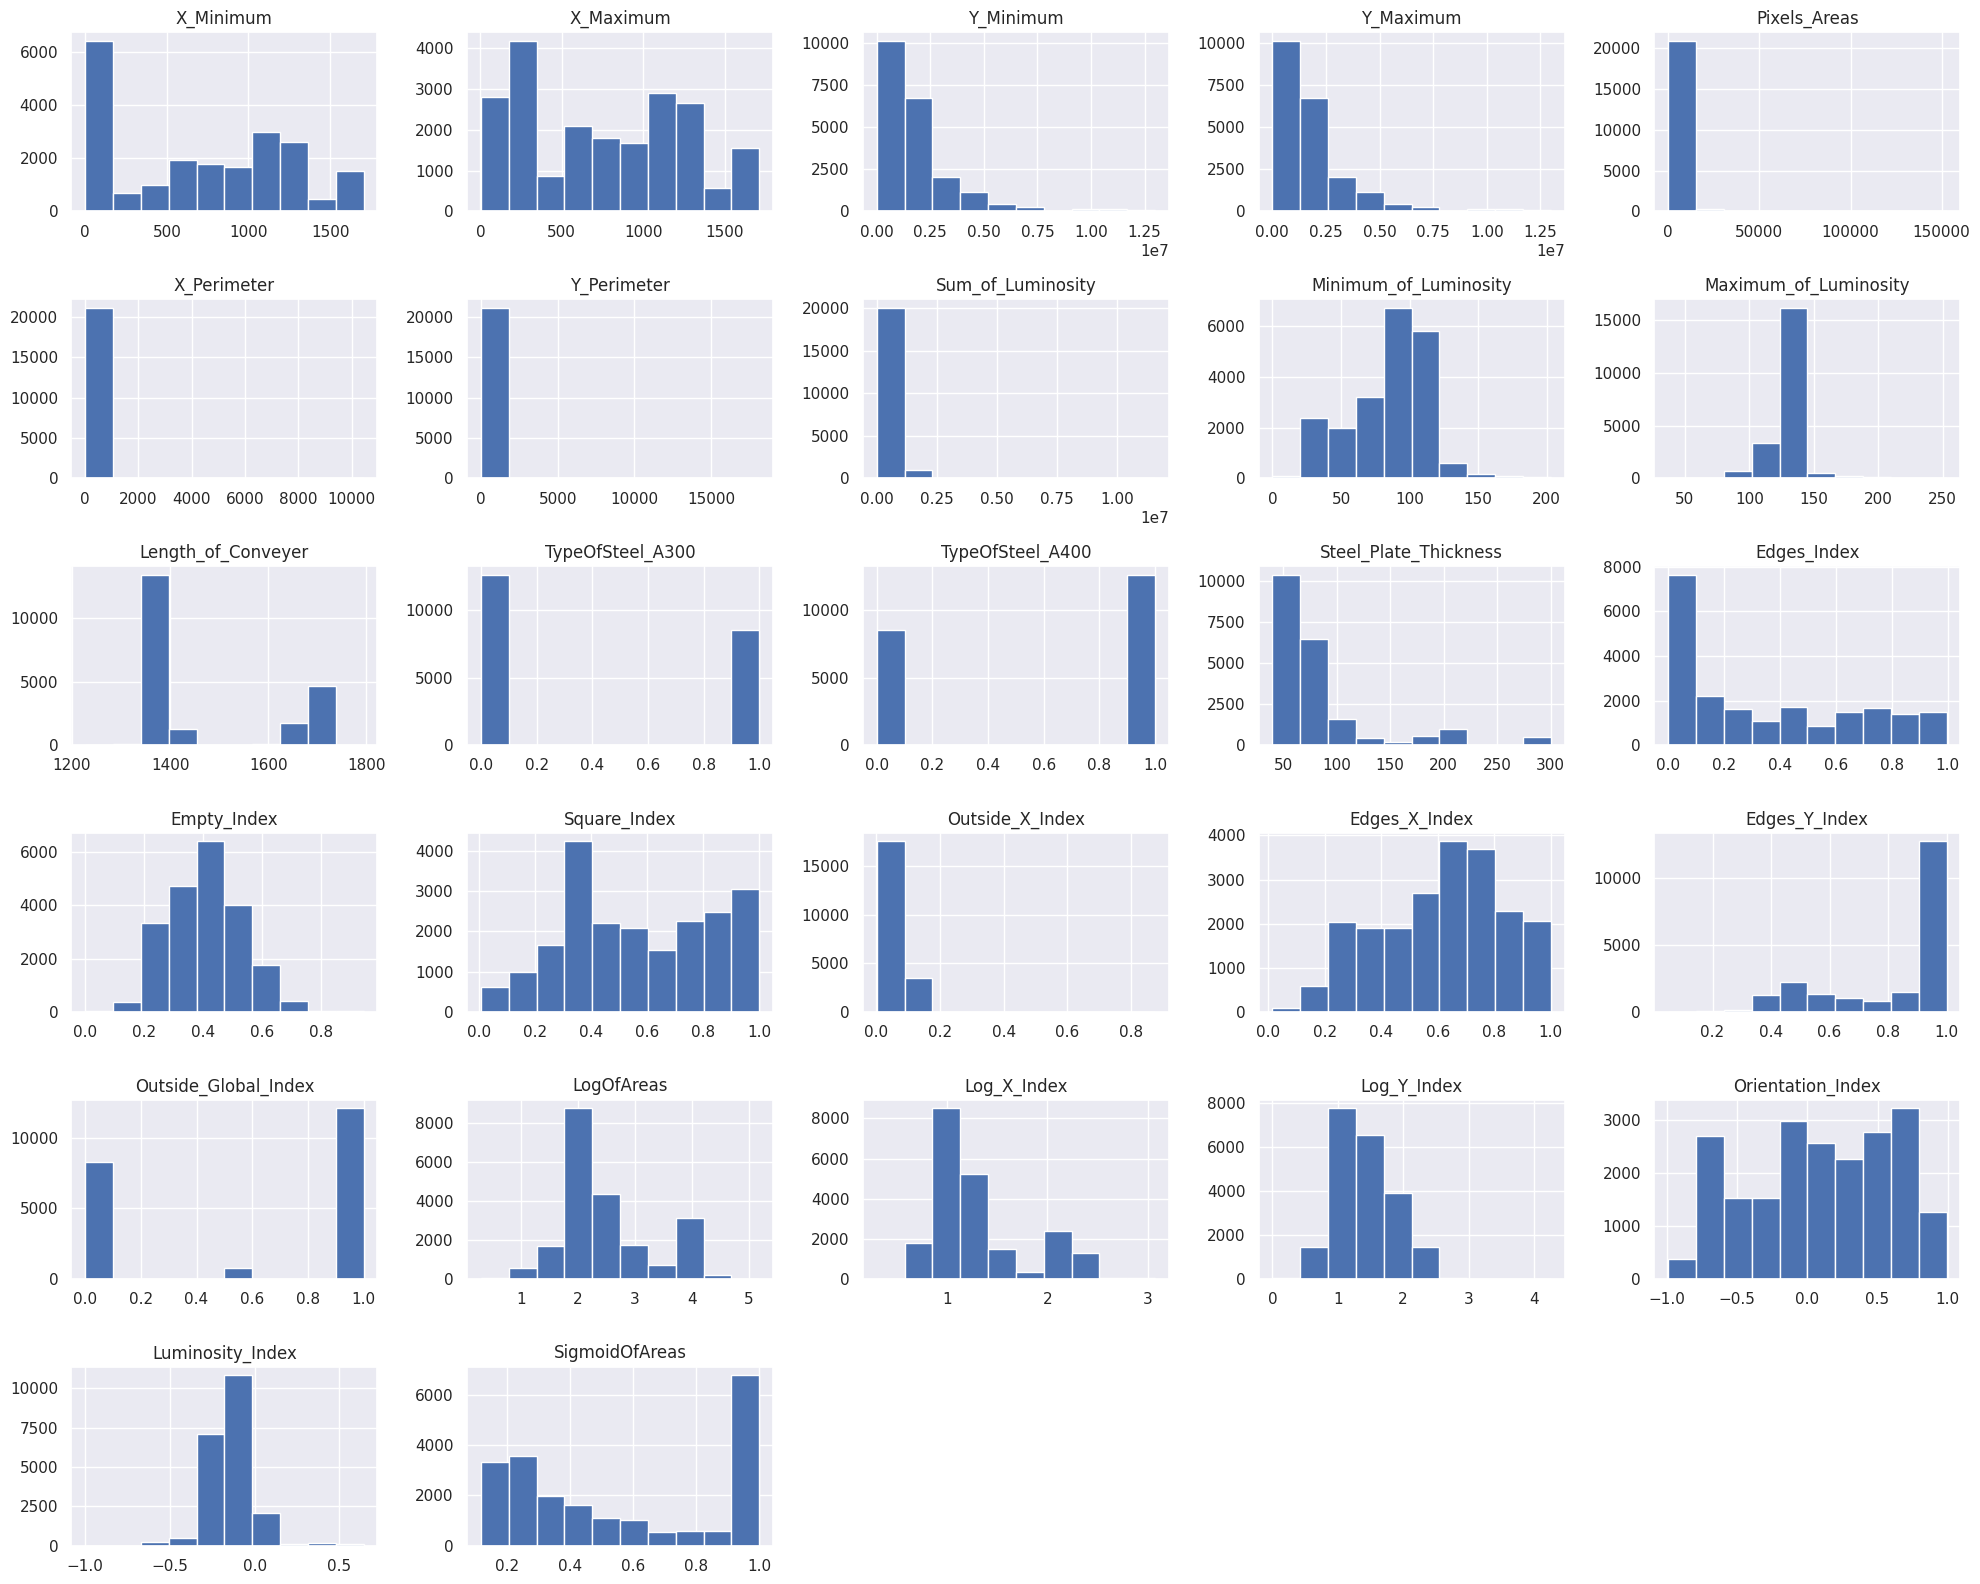

In [16]:
sns.set(rc={'figure.figsize':(20,16)});
X.hist();
plt.tight_layout()
plt.show()

In [17]:
y

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1936,0,0,0,0,0,0,1
1937,0,0,0,0,0,0,1
1938,0,0,0,0,0,0,1
1939,0,0,0,0,0,0,1


In [19]:
%%time

best_rf=RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=2,
    max_depth=15,
    min_samples_split=2,
    random_state=27
)

best_rf.fit(X,y)



CPU times: user 8.96 s, sys: 32.9 ms, total: 8.99 s
Wall time: 9.07 s


RandomForestClassifier(max_depth=15, min_samples_leaf=2, random_state=27)

In [20]:
importance=best_rf.feature_importances_
importance

array([0.03624988, 0.03670989, 0.02310145, 0.02335094, 0.064847  ,
       0.04144455, 0.03633403, 0.06029349, 0.0433713 , 0.02138943,
       0.04831608, 0.01322454, 0.01299974, 0.04965263, 0.03043509,
       0.02847858, 0.02945375, 0.08101707, 0.02420311, 0.02554809,
       0.00248823, 0.08202891, 0.06003526, 0.02733298, 0.03447648,
       0.03063516, 0.03258233])

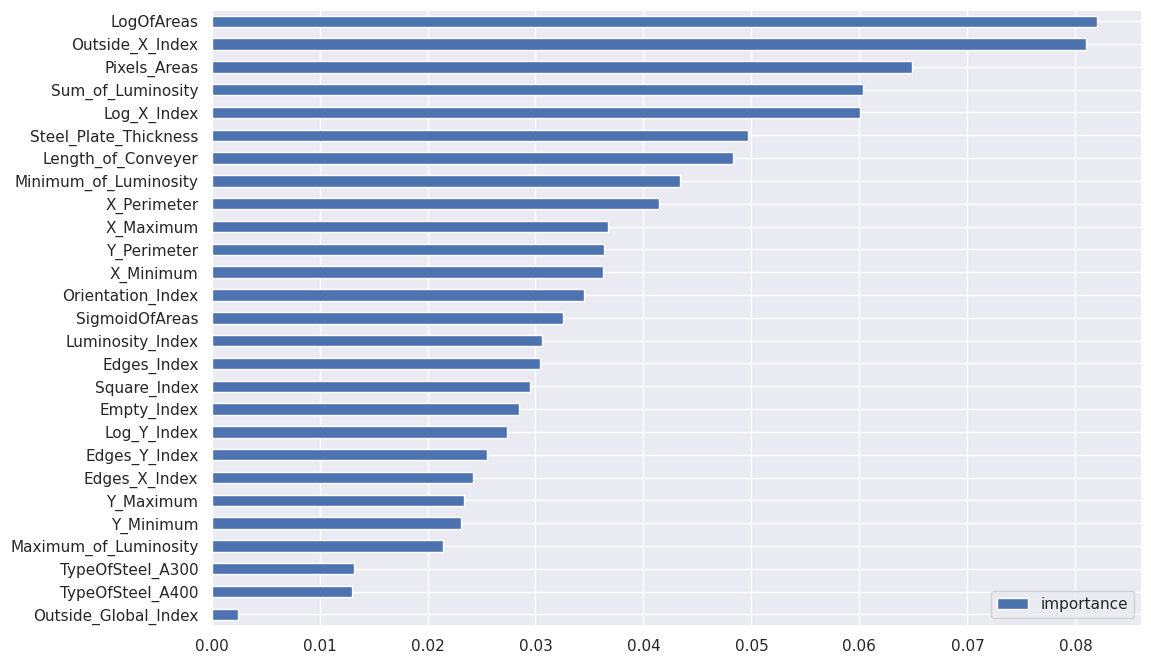

In [22]:
feature_importance=pd.DataFrame(data=importance,index=X.columns,columns=["importance"]) \
    .sort_values(by="importance",ascending=True) \
    .plot(kind='barh',figsize=(12,8))


### Creating and fitting the stacking model

In [52]:
base_models = [
    ('catboost', CatBoostClassifier(
#         iterations=356,
#         learning_rate=0.05523621532706332,
#         colsample_bylevel=0.9670482730500998,
#         min_data_in_leaf=51,
        depth=7,
#         l2_leaf_reg=0.09143367745503939,
        random_state=27,
    )),
    ('xgboost', XGBClassifier(
        max_depth=86,
#         learning_rate=0.010106655926896491,
#         n_estimators=807,
#         min_child_weight=8,
#         gamma=2.873626144298305e-06,
#         subsample=0.4070354062609407,
#         colsample_bytree=0.4756812939092108,
#         reg_alpha=1.36466606196441e-06,
#         reg_lambda=0.0005319872532608146,
        random_state=27,
    )),
    ('lightgmb', LGBMClassifier(
#         n_estimators=760,
        max_depth=96,
#         learning_rate=0.007160407548846659,
#         boosting_type='gbdt',
#         num_leaves=168,
#         min_child_samples=100,
        random_state=27,
    )),
    ('random_forest', RandomForestClassifier(
#         n_estimators=292,
#         criterion='log_loss',
#         min_samples_leaf=1,
        max_depth=58,
#         min_samples_split=14,
        random_state=27,
    )),
]

In [53]:
meta_model = CatBoostClassifier(
#     max_depth=86,
#     learning_rate=0.010106655926896491,
#     n_estimators=807,
#     min_child_weight=8,
#     gamma=2.873626144298305e-06,
#     subsample=0.4070354062609407,
#     colsample_bytree=0.4756812939092108,
#     reg_alpha=1.36466606196441e-06,
#     reg_lambda=0.0005319872532608146,
    random_state=27,
)

In [54]:
target_features = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
predictions_proba = pd.DataFrame()

models = []

for target_column in target_features:
    stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)
    stacking_model.fit(X, y[target_column])
    
    models.append(stacking_model)
    
    predictions_proba[target_column] = stacking_model.predict_proba(test)[:, 1]

Learning rate set to 0.037925
0:	learn: 0.6323266	total: 54.7ms	remaining: 54.7s
1:	learn: 0.5828255	total: 63.3ms	remaining: 31.6s
2:	learn: 0.5345955	total: 71.1ms	remaining: 23.6s
3:	learn: 0.5028388	total: 78.9ms	remaining: 19.6s
4:	learn: 0.4670859	total: 88.8ms	remaining: 17.7s
5:	learn: 0.4447349	total: 98.3ms	remaining: 16.3s
6:	learn: 0.4219264	total: 107ms	remaining: 15.2s
7:	learn: 0.3947955	total: 116ms	remaining: 14.4s
8:	learn: 0.3739805	total: 124ms	remaining: 13.7s
9:	learn: 0.3584618	total: 133ms	remaining: 13.2s
10:	learn: 0.3395434	total: 142ms	remaining: 12.7s
11:	learn: 0.3253454	total: 150ms	remaining: 12.3s
12:	learn: 0.3129038	total: 159ms	remaining: 12s
13:	learn: 0.3033034	total: 167ms	remaining: 11.7s
14:	learn: 0.2918306	total: 175ms	remaining: 11.5s
15:	learn: 0.2822115	total: 182ms	remaining: 11.2s
16:	learn: 0.2736343	total: 191ms	remaining: 11s
17:	learn: 0.2670358	total: 199ms	remaining: 10.9s
18:	learn: 0.2605289	total: 208ms	remaining: 10.7s
19:	learn

## Submission

In [55]:
predictions_proba



,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.744407,0.000114,0.000744,0.000017,0.055189,0.152226,0.356612
1,0.346237,0.017636,0.003362,0.000021,0.265733,0.115765,0.298800
2,0.000484,0.052554,0.052777,0.000081,0.002791,0.385827,0.489278
3,0.106364,0.000121,0.000070,0.000053,0.011857,0.508315,0.482962
4,0.000848,0.000079,0.000260,0.000652,0.009570,0.765933,0.370265
...,...,...,...,...,...,...,...
12809,0.100787,0.072235,0.000407,0.000016,0.030749,0.204073,0.476280
12810,0.061708,0.001290,0.016598,0.001576,0.060133,0.176258,0.354066
12811,0.000072,0.000060,0.995702,0.000017,0.000179,0.000105,0.051536
12812,0.258342,0.015778,0.011142,0.000016,0.057495,0.103881,0.312490


In [64]:
new_sub=pd.concat([submission.drop(labels=target_features,axis=1),predictions_proba],axis=1)
new_sub.to_csv("baseline.csv", index=False)